In [1]:
import pydicom
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from collections import defaultdict
from tqdm import tqdm  
import random
from tqdm.notebook import tqdm

In [ ]:
# Preform Skull Stripping
input_folder = 'D:\\CTH_archive\\CTP_NIFTI'
output_folder = 'D:\\CTH_archive\\CTP_Segmented_NIFTI'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        # Extract the patient name from the filename
        patient_name = filename.split(' ')[0]
        
        input_path = os.path.join(input_folder, filename)
        # Use the patient name to construct the output path
        output_path = os.path.join(output_folder, f'{patient_name}.nii')
        
        # Check if the input file exists before trying to load it
        if os.path.exists(input_path):
            # Check if the output file already exists before processing the input file
            if not os.path.exists(output_path):
                try:
                    input_img = nib.load(input_path)
                    totalsegmentator(input_img, output_path, roi_subset=['brain'], ml=True)
                    print(f"Processed and saved: {output_path}")
                except Exception as e:
                    print(f"Error processing file {input_path}: {e}")
            else:
                print(f"Output file already exists, not overwriting: {output_path}")
        else:
            print(f"Input file does not exist: {input_path}")

In [ ]:
# Apply the skull stripping mask to the original image

import os
import nibabel as nib
import numpy as np

original_dir = 'D:\\CTH_archive\\CTP_NIFTI'
mask_dir = 'D:\\CTH_archive\\CTP_Segmented_NIFTI'
output_dir = 'D:\\CTH_archive\\CTP_STRIPPED'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Iterate over the mask files
for mask_filename in os.listdir(mask_dir):
    # Strip the extension from the mask filename
    base_filename = os.path.splitext(os.path.splitext(mask_filename)[0])[0]

    # Check for a matching file in the original_dir
    for original_filename in os.listdir(original_dir):
        original_base_filename = os.path.splitext(os.path.splitext(original_filename)[0])[0]
        if original_base_filename == base_filename:
            original_path = os.path.join(original_dir, original_filename)
            break
    else:
        print(f"No matching file found for {mask_filename}")
        continue

    # Construct the mask file path
    mask_path = os.path.join(mask_dir, mask_filename)

    print(f"Applying mask to {original_path} using {mask_path}")
    
    # Load the mask and original image
    mask_nii = nib.load(mask_path)
    original_nii = nib.load(original_path)

    # Get the data as numpy arrays
    mask_data = mask_nii.get_fdata()
    original_data = original_nii.get_fdata()

    # Apply the mask (blackout non-masked areas)
    masked_data = np.where(mask_data > 0, original_data, 0)

    # Create a new NIFTI image from the masked data
    masked_nii = nib.Nifti1Image(masked_data, affine=original_nii.affine)

    # Save the masked image
    output_path = os.path.join(output_dir, mask_filename)
    nib.save(masked_nii, output_path)

print("Mask application complete.")

In [ ]:
def convert_series_to_nifti(input_directory, output_file):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(input_directory)
    reader.SetFileNames(dicom_names)
    image_series = reader.Execute()
    
    # Convert to numpy array to manipulate the pixel data directly
    img_array = sitk.GetArrayFromImage(image_series)
        
    # Convert the numpy array back to a SimpleITK Image
    processed_image = sitk.GetImageFromArray(img_array)
    processed_image.SetSpacing(image_series.GetSpacing())
    processed_image.SetOrigin(image_series.GetOrigin())
    processed_image.SetDirection(image_series.GetDirection())

    # Write the processed image as a NIfTI file
    sitk.WriteImage(processed_image, output_file)

In [2]:
def register_images(fixed_image_path, moving_image_path, transforms_dir):
    # Extract patient identifier from the file name
    patient = os.path.splitext(os.path.basename(moving_image_path))[0]

    # Load the fixed and moving images
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)

    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingPercentage(0.6, sitk.sitkWallClock)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=0.5, numberOfIterations=300, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[8, 4, 2])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2, 1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Initialize the transform with a better starting point for images with minimal initial overlap
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image, moving_image.GetPixelID()), 
                                                          moving_image, 
                                                          sitk.AffineTransform(fixed_image.GetDimension()),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform, True)

    try:
        # Execute the registration
        final_transform = registration_method.Execute(fixed_image, moving_image)
        
        # Resample the moving image
        resampled_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

        # Save the transform and resampled image
        transform_file = os.path.join(transforms_dir, f'{patient}_transform.h5')
        sitk.WriteTransform(final_transform, transform_file)
        
        print(f"Registration successful for patient: {patient}. Transform saved to {transform_file}")
    except RuntimeError as e:
        print(f"Registration failed for patient {patient}: {e}")

fixed_images_dir = "D:/CTH_archive/CTH_STRIPPED"
moving_images_dir = "D:/CTH_archive/CTP_STRIPPED"
transforms_dir = "D:/CTH_archive/Transforms_STRIPPED"

if not os.path.exists(transforms_dir):
    os.makedirs(transforms_dir)

for filename in os.listdir(fixed_images_dir):
    fixed_image_path = os.path.join(fixed_images_dir, filename)
    moving_image_path = os.path.join(moving_images_dir, filename)

    if os.path.isfile(fixed_image_path) and os.path.isfile(moving_image_path):
        register_images(fixed_image_path, moving_image_path, transforms_dir)


Registration successful for patient: ALLAH_MAJUSTICE. Transform saved to D:/CTH_archive/Transforms_STRIPPED\ALLAH_MAJUSTICE_transform.h5
Registration successful for patient: BATTLE_MARIA. Transform saved to D:/CTH_archive/Transforms_STRIPPED\BATTLE_MARIA_transform.h5
Registration successful for patient: BOGER_DAVID_S. Transform saved to D:/CTH_archive/Transforms_STRIPPED\BOGER_DAVID_S_transform.h5
Registration successful for patient: BROWN_ANTHONY. Transform saved to D:/CTH_archive/Transforms_STRIPPED\BROWN_ANTHONY_transform.h5
Registration successful for patient: CANIGLIA_ROBERT. Transform saved to D:/CTH_archive/Transforms_STRIPPED\CANIGLIA_ROBERT_transform.h5
Registration successful for patient: CARDIN_PAUL. Transform saved to D:/CTH_archive/Transforms_STRIPPED\CARDIN_PAUL_transform.h5
Registration successful for patient: CHANG_WAH_KONG. Transform saved to D:/CTH_archive/Transforms_STRIPPED\CHANG_WAH_KONG_transform.h5
Registration successful for patient: CHEN_QIAOYING. Transform sav

KeyboardInterrupt: 

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive_output
from IPython.display import display

def display_image_slices(fixed_image_path, moving_image_path, transform_path):
    # Read the fixed and moving images using SimpleITK
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)
    
    # Read the transform
    transform = sitk.ReadTransform(transform_path)

    # Apply the transform to the moving image
    transformed_image = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

    # Convert SimpleITK images to arrays for easier manipulation
    fixed_image_array = sitk.GetArrayFromImage(fixed_image)
    transformed_image_array = sitk.GetArrayFromImage(transformed_image)

    # Determine the maximum number of slices from the fixed and transformed images
    max_slices = max(fixed_image.GetSize()[2], transformed_image.GetSize()[2])

    def update_slice(slice_idx):
        # Create figure with 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the fixed image slice
        axs[0].imshow(fixed_image_array[slice_idx], cmap='gray')
        axs[0].set_title('Fixed Image')

        # Display the overlay: fixed image slice with the transformed image slice overlaid with transparency
        if slice_idx < transformed_image_array.shape[0]:
            axs[1].imshow(fixed_image_array[slice_idx], cmap='gray')
            axs[1].imshow(transformed_image_array[slice_idx], cmap='jet', alpha=0.5)  # Adjust alpha for desired transparency
            axs[1].set_title('Overlay: Fixed + Transformed Image')
        else:
            axs[1].text(0.5, 0.5, 'Slice not available', horizontalalignment='center', verticalalignment='center')
            axs[1].set_title('Overlay: Fixed + Transformed Image')

        plt.show()

    # Create a slider widget for slice selection
    slice_slider = widgets.IntSlider(min=0, max=max_slices-1, step=1, value=max_slices//2, description='Slice')

    # Display the widget and use `interactive_output` to connect the slider with the update function
    interactive_output = widgets.interactive_output(update_slice, {'slice_idx': slice_slider})
    display(slice_slider, interactive_output)

def display_patient_slices(patient_name):
    fixed_image_path = f"D:/CTH_archive/CTH_STRIPPED/{patient_name}.nii"
    moving_image_path = f"D:/CTH_archive/CTP_STRIPPED/{patient_name}.nii"
    transform_path = f"D:/CTH_archive/Transforms_STRIPPED/{patient_name}_transform.h5"
    
    display_image_slices(fixed_image_path, moving_image_path, transform_path)

# Example usage with a generic patient name
display_patient_slices("LATTEIER_MARIA")



RuntimeError: Exception thrown in SimpleITK ReadTransform: D:\a\1\sitk-build\ITK\Modules\IO\TransformBase\src\itkTransformFileReader.cxx:128:
ITK ERROR: TransformFileReaderTemplate(00000253D5FD7070): Could not create Transform IO object for reading file D:/CTH_archive/Transforms_STRIPPED/LATTEIER_MARIA_transform.h5
 File does not exists!  Tried to create one of the following:
    HDF5TransformIOTemplate
    HDF5TransformIOTemplate
    MINCTransformIOTemplate
    MINCTransformIOTemplate
    MatlabTransformIOTemplate
    MatlabTransformIOTemplate
    TxtTransformIOTemplate
    TxtTransformIOTemplate
  You probably failed to set a file suffix, or
    set the suffix to an unsupported type.


In [34]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def display_image_slice(fixed_image, moving_image, transform, slice_idx):
    # Apply transform to the moving image
    transformed_image = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

    # Convert SimpleITK images to NumPy arrays for visualization
    fixed_image_array = sitk.GetArrayFromImage(fixed_image)
    transformed_image_array = sitk.GetArrayFromImage(transformed_image)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_image_array[slice_idx], cmap='gray')
    plt.title('Fixed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fixed_image_array[slice_idx], cmap='gray')
    plt.imshow(transformed_image_array[slice_idx], cmap='jet', alpha=0.5)
    plt.title('Transformed Moving Image')
    plt.axis('off')

    plt.show()

def update_display(patient_name, slice_idx):
    # Clear the previous output
    with image_output_area:
        clear_output(wait=True)

        # Construct the file paths based on the selected patient name
        fixed_image_path = f"D:/CTH_archive/CTH_STRIPPED/{patient_name}.nii"
        moving_image_path = f"D:/CTH_archive/CTP_STRIPPED/{patient_name}.nii"
        transform_path = f"D:/CTH_archive/Transforms_STRIPPED/{patient_name}_transform.h5"

        # Load images and transform
        fixed_image = sitk.ReadImage(fixed_image_path)
        moving_image = sitk.ReadImage(moving_image_path)
        transform = sitk.ReadTransform(transform_path)

        # Display the selected image slice
        display_image_slice(fixed_image, moving_image, transform, slice_idx)

# Directory path containing the patient files
directory_path = "D:/CTH_archive/CTH_STRIPPED"
patient_names = [os.path.splitext(file)[0] for file in os.listdir(directory_path) if file.endswith('.nii')]

# Create dropdown for patient selection
patient_dropdown = widgets.Dropdown(options=patient_names, description='Patient:')

# Initialize slider for slice navigation with a placeholder range
slice_slider = widgets.IntSlider(min=0, max=1, value=0, description='Slice:', continuous_update=False)

# Function to handle changes in patient selection
def on_patient_change(change):
    # Extract the new patient name using key access
    new_patient_name = change['new']
    
    # Update the slider's range based on the new patient's image dimensions
    fixed_image_path = f"D:/CTH_archive/CTH_STRIPPED/{new_patient_name}.nii"
    fixed_image = sitk.ReadImage(fixed_image_path)
    num_slices = fixed_image.GetSize()[2]
    slice_slider.max = num_slices - 1  # Adjust for zero-based indexing
    
    # Update the displayed image slice
    update_display(new_patient_name, slice_slider.value)


# Observe changes in patient selection
patient_dropdown.observe(on_patient_change, names='value')

# Function to handle changes in slice navigation
def on_slice_change(change):
    update_display(patient_dropdown.value, change.new)

# Observe changes in slice navigation
slice_slider.observe(on_slice_change, names='value')

# Display the widgets
display(patient_dropdown)
display(slice_slider)

# Separate output area for images
image_output_area = widgets.Output()
display(image_output_area)

# Initialize display with the first patient's name and first slice
if patient_names:
    initial_change = {'name': 'value', 'old': patient_names[0], 'new': patient_names[0], 'owner': patient_dropdown, 'type': 'change'}
    on_patient_change(initial_change)


Dropdown(description='Patient:', options=('ALFORD_BARBARA', 'ALLAH_MAJUSTICE', 'BATTLE_MARIA', 'BOGER_DAVID_S'…

IntSlider(value=0, continuous_update=False, description='Slice:', max=1)

Output()

Inital File Set Orgnaizaiton

In [ ]:
directories = ["D:\\CTH_archive\\TMAX_DICOM", "D:\\CTH_archive\\CTH_DICOM_RESIZE", "D:\\CTH_archive\\CTP_DICOM"]
directory_names = ["TMAX_DICOM", "CTH_DICOM_RESIZE", "CTP_DICOM"]

# Initialize a dictionary to store file paths organized by patient name/MRN
patient_files = defaultdict(lambda: defaultdict(list))

# Process each directory
for directory, dir_name in zip(directories, directory_names):
    print(f"Processing directory: {directory}")
    if os.path.exists(directory):
        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                # Split the path to extract the patient name
                parts = root.split("\\")
                # Find the index of the main directory to ensure the patient name is correctly extracted
                try:
                    index = parts.index(dir_name) + 1
                    patient_name = parts[index]
                    patient_files[patient_name][dir_name].append(file_path)
                except (IndexError, ValueError) as e:
                    print(f"Error processing {file_path}: {e}")
    else:
        print(f"Error: Directory {directory} does not exist")

# Filter patients with files in all three directories and store in a new variable
patients_with_all_folders= {
    patient: folders for patient, folders in patient_files.items()
    if set(folders.keys()) == set(directory_names)
}

print("Number of patients with all folders:", len(patients_with_all_folders))

In [ ]:
def read_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    if image.GetNumberOfComponentsPerPixel() > 1:
        channels = [sitk.VectorIndexSelectionCast(image, i) for i in range(image.GetNumberOfComponentsPerPixel())]
        image = sum(channels) / len(channels)

    image = sitk.Cast(image, sitk.sitkFloat32)
    return image


In [ ]:
transforms_dir = r'D:\CTH_archive\Transforms'  # Directory to save the transforms
if not os.path.exists(transforms_dir):
    os.makedirs(transforms_dir)

resampled_images = {}  # To store the resampled images for each patient
resampled_images_transform = {}  # To store the transform files for each patient

def remove_background(image):
    threshold_value = -500  # May need to tweak this but okay for now
    binary_image = sitk.BinaryThreshold(image, lowerThreshold=threshold_value, upperThreshold=3000, insideValue=1, outsideValue=0)
    morph_radius = [2, 2, 2] 
    binary_image = sitk.BinaryMorphologicalOpening(binary_image, morph_radius)
    cc_filter = sitk.ConnectedComponentImageFilter()
    cc_image = cc_filter.Execute(binary_image)
    stats_filter = sitk.LabelIntensityStatisticsImageFilter()
    stats_filter.Execute(cc_image, binary_image)
    largest_label = max(stats_filter.GetLabels(), key=lambda x: stats_filter.GetPhysicalSize(x))
    binary_image = sitk.BinaryThreshold(cc_image, lowerThreshold=largest_label, upperThreshold=largest_label, insideValue=1, outsideValue=0)
    
    # Cast the binary_image to the same pixel type as the original image
    casted_binary_image = sitk.Cast(binary_image, image.GetPixelID())

    return image * casted_binary_image

for patient in tqdm(patients_with_all_folders, desc='Processing Patients'):
    if 'CTP_DICOM' in patient_files[patient] and 'CTH_DICOM_RESIZE' in patient_files[patient]:
        ctp_dicom_directory = os.path.dirname(patient_files[patient]['CTP_DICOM'][0])
        CTH_DICOM_RESIZE_directory = os.path.dirname(patient_files[patient]['CTH_DICOM_RESIZE'][0])

        # Read DICOM series
        moving_image = read_dicom_series(ctp_dicom_directory)
        fixed_image = read_dicom_series(CTH_DICOM_RESIZE_directory)
        
        # Remove background from the moving and fixed images
        segmented_moving_image = remove_background(moving_image)
        segmented_fixed_image = remove_background(fixed_image)
        
    
           # Read DICOM series and apply histogram normalization
        moving_image = read_dicom_series(ctp_dicom_directory)
        moving_image_min = float(sitk.GetArrayFromImage(moving_image).min())
        moving_image_max = float(sitk.GetArrayFromImage(moving_image).max())
        moving_image = sitk.IntensityWindowing(moving_image,
                                            windowMinimum=moving_image_min,
                                            windowMaximum=moving_image_max,
                                            outputMinimum=0.0,
                                            outputMaximum=1.0)

        fixed_image = read_dicom_series(CTH_DICOM_RESIZE_directory)
        fixed_image_min = float(sitk.GetArrayFromImage(fixed_image).min())
        fixed_image_max = float(sitk.GetArrayFromImage(fixed_image).max())
        fixed_image = sitk.IntensityWindowing(fixed_image,
                                            windowMinimum=fixed_image_min,
                                            windowMaximum=fixed_image_max,
                                            outputMinimum=0.0,
                                            outputMaximum=1.0)


        """fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        axs[0, 0].imshow(sitk.GetArrayFromImage(fixed_image)[fixed_image.GetSize()[2] // 2], cmap='gray')
        axs[0, 0].set_title('Original Fixed Image')
        axs[0, 0].axis('off')
        axs[0, 1].imshow(sitk.GetArrayFromImage(segmented_fixed_image)[fixed_image.GetSize()[2] // 2], cmap='gray')
        axs[0, 1].set_title('Segmented Fixed Image')
        axs[0, 1].axis('off')
        axs[1, 0].imshow(sitk.GetArrayFromImage(moving_image)[moving_image.GetSize()[2] // 2], cmap='gray')
        axs[1, 0].set_title('Original Moving Image')
        axs[1, 0].axis('off')
        axs[1, 1].imshow(sitk.GetArrayFromImage(segmented_moving_image)[moving_image.GetSize()[2] // 2], cmap='gray')
        axs[1, 1].set_title('Segmented Moving Image')
        axs[1, 1].axis('off')
        plt.show()"""

        registration_method = sitk.ImageRegistrationMethod()
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        registration_method.SetMetricSamplingPercentage(0.6, sitk.sitkWallClock)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=0.5, numberOfIterations=300, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
        registration_method.SetOptimizerScalesFromPhysicalShift()
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[8, 4, 2])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2, 1])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.AffineTransform(fixed_image.GetDimension()), sitk.CenteredTransformInitializerFilter.MOMENTS)
        registration_method.SetInitialTransform(initial_transform)
        try:
            final_transform = registration_method.Execute(segmented_fixed_image, segmented_moving_image)
            resampled_image = sitk.Resample(segmented_moving_image, segmented_fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
            resampled_images[patient] = resampled_image
            transform_file = os.path.join(transforms_dir, f'{patient}_transform.h5')
            sitk.WriteTransform(final_transform, transform_file)
            resampled_images_transform[patient] = transform_file
            print(f"Registration successful for patient: {patient}. Transform saved to {transform_file}")
        except RuntimeError as e:
            print(f"Registration failed for patient {patient}: {e}")



In [8]:
def display_image_slices(fixed_image, moving_image, transformed_image):
    # Convert SimpleITK images to arrays for easier manipulation
    fixed_image_array = sitk.GetArrayFromImage(fixed_image)
    transformed_image_array = sitk.GetArrayFromImage(transformed_image)

    # Determine the maximum number of slices from the fixed and transformed images
    max_slices = max(fixed_image.GetSize()[2], transformed_image.GetSize()[2])

    def update_slice(slice_idx):
        # Create figure with 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the fixed image slice
        axs[0].imshow(fixed_image_array[slice_idx], cmap='gray')
        axs[0].set_title('Fixed Image')

        # Display the overlay: fixed image slice with the transformed image slice overlaid with transparency
        if slice_idx < transformed_image_array.shape[0]:
            axs[1].imshow(fixed_image_array[slice_idx], cmap='gray')
            axs[1].imshow(transformed_image_array[slice_idx], cmap='jet', alpha=0.5)  # Adjust alpha for desired transparency
            axs[1].set_title('Overlay: Fixed + Transformed Image')
        else:
            axs[1].text(0.5, 0.5, 'Slice not available', horizontalalignment='center', verticalalignment='center')
            axs[1].set_title('Overlay: Fixed + Transformed Image')

        plt.show()

    # Create a slider widget for slice selection
    slice_slider = widgets.IntSlider(min=0, max=max_slices-1, step=1, value=max_slices//2, description='Slice')

    # Display the widget and use `interactive_output` to connect the slider with the update function
    interactive_output = widgets.interactive_output(update_slice, {'slice_idx': slice_slider})
    display(slice_slider, interactive_output)

In [ ]:
def display_fusion(fixed_image, registered_image):
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    registered_array = sitk.GetArrayFromImage(registered_image)

    # Ensure the images are in the same size for overlay
    registered_resampled = sitk.Resample(registered_image, fixed_image)

    # Convert SimpleITK images to arrays
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    registered_array = sitk.GetArrayFromImage(registered_resampled)

    # Choose a slice in the middle of the volume to display
    slice_idx = fixed_array.shape[0] // 2

    # Create a fusion image by overlaying the registered image on the fixed image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_array[slice_idx], cmap='gray')
    plt.title('Fixed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fixed_array[slice_idx], cmap='gray')
    plt.imshow(registered_array[slice_idx], cmap='jet', alpha=0.5)  # Adjust alpha for transparency
    plt.title('Fusion Visualization')
    plt.axis('off')

    plt.show()

In [ ]:
def convert_series_to_nifti(input_directory, output_file):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(input_directory)
    reader.SetFileNames(dicom_names)
    image_series = reader.Execute()
    
    # Convert to numpy array to manipulate the pixel data directly
    img_array = sitk.GetArrayFromImage(image_series)

    # Check if the image needs to be converted to grayscale
    if image_series.GetNumberOfComponentsPerPixel() > 1:
        img_array = np.mean(img_array, axis=-1).astype(np.uint16)

        img_array[:, :35, :] = 0  # Remove TAMX label
        img_array[:, :, :35] = 0 # Remove scale on  the left
    
    # Convert the numpy array back to a SimpleITK Image
    processed_image = sitk.GetImageFromArray(img_array)
    processed_image.SetSpacing(image_series.GetSpacing())
    processed_image.SetOrigin(image_series.GetOrigin())
    processed_image.SetDirection(image_series.GetDirection())

    # Write the processed image as a NIfTI file
    sitk.WriteImage(processed_image, output_file)

root_directory = r'D:\CTH_archive\TMAX_DICOM'

for patient_dir in os.listdir(root_directory):
    patient_path = os.path.join(root_directory, patient_dir)
    if os.path.isdir(patient_path):
        for series_dir in os.listdir(patient_path):
            series_path = os.path.join(patient_path, series_dir)
            if os.path.isdir(series_path):
                output_nifti_file = os.path.join(patient_path, f"{series_dir}.nii")
                print(f"Converting {series_path} to NIfTI...")
                convert_series_to_nifti(series_path, output_nifti_file)

In [ ]:
CTH_ARCHIVE_DIR = r'D:\CTH_archive'
TMAX_DICOM_DIR = os.path.join(CTH_ARCHIVE_DIR, 'TMAX_DICOM')
CTP_DICOM_DIR = os.path.join(CTH_ARCHIVE_DIR, 'CTP_DICOM')
CTH_DICOM_RESIZE_DIR = os.path.join(CTH_ARCHIVE_DIR, 'CTH_DICOM_RESIZE')
REGISTERED_NIFTI_DIR = os.path.join(CTH_ARCHIVE_DIR, 'Registered_NIfTI')

if not os.path.exists(REGISTERED_NIFTI_DIR):
    os.makedirs(REGISTERED_NIFTI_DIR)

# Function to resample the moving image
def resample_image(moving_image, fixed_image, ctp_image):
    desired_size = [fixed_image.GetSize()[0], fixed_image.GetSize()[1], ctp_image.GetSize()[2]]
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(moving_image)
    resampler.SetSize(desired_size)
    resampler.SetOutputSpacing([moving_image.GetSpacing()[i] * (moving_image.GetSize()[i] / desired_size[i]) for i in range(3)])
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkLinear)
    resized_moving_image = resampler.Execute(moving_image)
    resized_moving_image.SetSpacing(ctp_image.GetSpacing())
    resized_moving_image.SetOrigin(ctp_image.GetOrigin())
    resized_moving_image.SetDirection(ctp_image.GetDirection())
    return resized_moving_image

# Function to apply the final transform to the resized moving image
def apply_final_transform(resized_moving_image, fixed_image, transform_file_path):
    if not os.path.exists(transform_file_path):
        print(f"Transform file not found at {transform_file_path}.")
        return None
    final_transform = sitk.ReadTransform(transform_file_path)
    resampled_image = sitk.Resample(resized_moving_image, 
                                    fixed_image, 
                                    final_transform, 
                                    sitk.sitkLinear, 
                                    0.0, 
                                    fixed_image.GetPixelID())
    return resampled_image

# Function to save the resampled image
def save_resampled_image(resampled_image, patient_id):
    output_path = os.path.join(REGISTERED_NIFTI_DIR, f'{patient_id}_registered.nii')
    sitk.WriteImage(resampled_image, output_path)
    print(f'output_path: {output_path}')

# Function to process each patient
def process_patient(patient_id):
    patient_directory = os.path.join(TMAX_DICOM_DIR, patient_id)
    nifti_files = [f for f in os.listdir(patient_directory) if f.endswith('.nii')]
    if not nifti_files:
        print(f"No NIfTI file found for patient {patient_id}.")
        return None, None, None
    nifti_file = nifti_files[0]
    nifti_file_path = os.path.join(patient_directory, nifti_file)
    moving_image = sitk.ReadImage(nifti_file_path)
    ctp_directory_base = os.path.join(CTP_DICOM_DIR, patient_id)
    study_dirs = [d for d in os.listdir(ctp_directory_base) if os.path.isdir(os.path.join(ctp_directory_base, d))]
    if not study_dirs:
        print(f"No CTP study found for patient {patient_id} in {ctp_directory_base}.")
        return None, None, None
    ctp_directory = os.path.join(ctp_directory_base, study_dirs[0])
    ctp_image = read_dicom_series(ctp_directory)
    fixed_image_base_dir = os.path.join(CTH_DICOM_RESIZE_DIR, patient_id)
    series_dirs = [d for d in os.listdir(fixed_image_base_dir) if os.path.isdir(os.path.join(fixed_image_base_dir, d))]
    if not series_dirs:
        print(f"No DICOM series found for patient {patient_id} in {fixed_image_base_dir}.")
        return None, None, None
    fixed_image_dir = os.path.join(fixed_image_base_dir, series_dirs[0])
    fixed_image = read_dicom_series(fixed_image_dir)
    resized_moving_image = resample_image(moving_image, fixed_image, ctp_image)
    transform_file_path = resampled_images_transform[patient_id]
    resampled_image = apply_final_transform(resized_moving_image, fixed_image, transform_file_path)
    if resampled_image is not None:
        save_resampled_image(resampled_image, patient_id)
        print(f"Processed and saved registered image for patient: {patient_id}")
    return fixed_image, moving_image, resampled_image

# Main function to process all patients
def process_all_patients():
    successful_patients = list(resampled_images.keys())
    random_subset = random.sample(successful_patients, 20)  # Select 20 random patient IDs
    for patient_id in successful_patients:
        fixed_image, moving_image, resampled_image = process_patient(patient_id)
        if patient_id in random_subset:
            display_image_slices(fixed_image, moving_image, resampled_image)
            print(f"Displayed image slices for patient: {patient_id}")

process_all_patients()

File RAMIREZ_ELIZABETH 2099072_registered.nii: Mean TMAX = 24.079370498657227, Median TMAX = 0.0, Std Dev TMAX = 62.08951950073242, Min TMAX = 0.0, Max TMAX = 255.0, Non-zero pixels = 1231252, Total pixels = 8388608


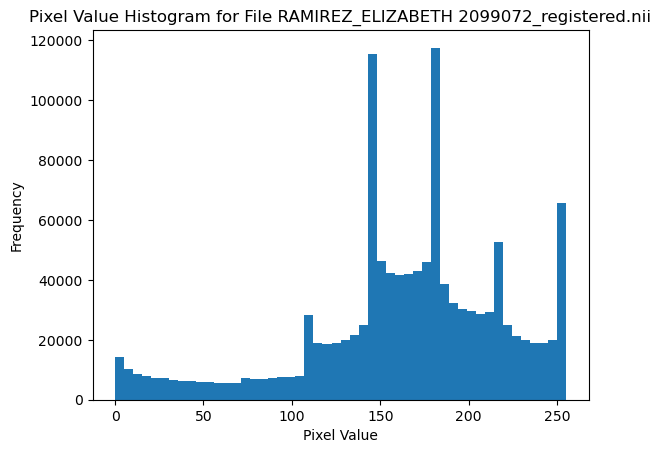

File HECKSTALL_CORA 460638_registered.nii: Mean TMAX = 20.659317016601562, Median TMAX = 0.0, Std Dev TMAX = 53.54856491088867, Min TMAX = 0.0, Max TMAX = 255.0, Non-zero pixels = 1300556, Total pixels = 8388608


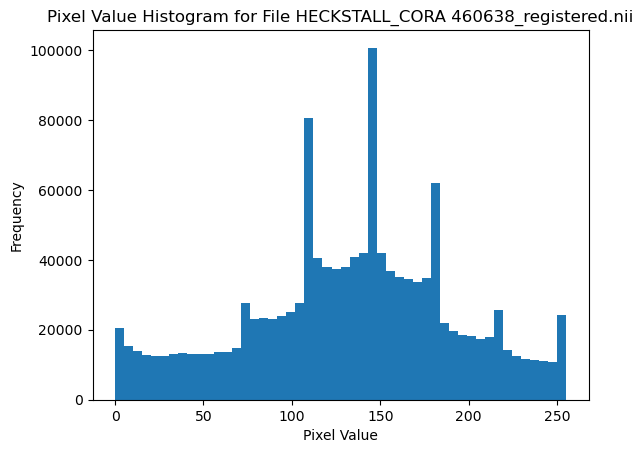

File RUBALLO_OMAR E951675_registered.nii: Mean TMAX = 21.621780395507812, Median TMAX = 0.0, Std Dev TMAX = 53.59587478637695, Min TMAX = 0.0, Max TMAX = 255.0, Non-zero pixels = 1311158, Total pixels = 8126464


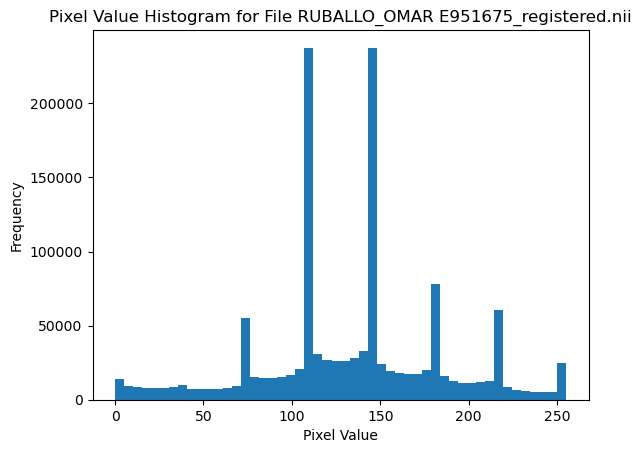

File KILLACKEY_WILLIAM K100636_registered.nii: Mean TMAX = 26.464000701904297, Median TMAX = 0.0, Std Dev TMAX = 65.2380599975586, Min TMAX = 0.0, Max TMAX = 255.0, Non-zero pixels = 1428210, Total pixels = 8912896


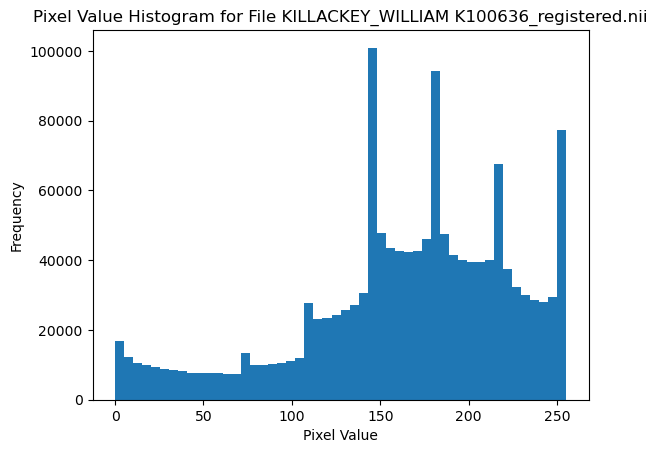

File MONTERO_RAMIREZ_MICAELA 5665111_registered.nii: Mean TMAX = 3.497133255004883, Median TMAX = 0.0, Std Dev TMAX = 16.849430084228516, Min TMAX = 0.0, Max TMAX = 255.0, Non-zero pixels = 460604, Total pixels = 8388608


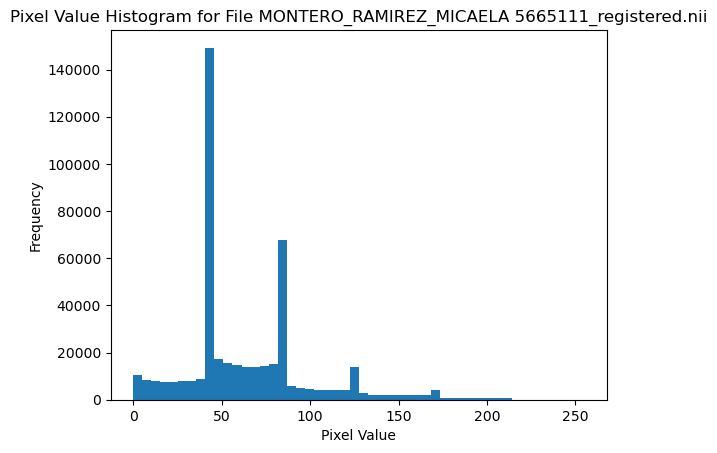

File DUMA_ZBIGNIEW F328178_registered.nii: Mean TMAX = 26.2081298828125, Median TMAX = 0.0, Std Dev TMAX = 63.09120559692383, Min TMAX = 0.0, Max TMAX = 255.0, Non-zero pixels = 1326136, Total pixels = 7864320


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
import random
import os
import SimpleITK as sitk
import numpy as np

TMAX_DICOM_DIR = r"D:/CTH_archive/Registered_NIfTI"

# Function to load TMAX maps and calculate statistics
def analyze_tmax_maps():
    nifti_files = [f for f in os.listdir(TMAX_DICOM_DIR) if f.endswith('.nii')]
    
    # Select 20 random nifti files
    selected_nifti_files = random.sample(nifti_files, 20)
    
    for nifti_file in selected_nifti_files:
        nifti_file_path = os.path.join(TMAX_DICOM_DIR, nifti_file)
        tmax_map = sitk.GetArrayFromImage(sitk.ReadImage(nifti_file_path))
        
        # Normalize the pixel values to the range 0-255
        tmax_map = (tmax_map - np.min(tmax_map)) / (np.max(tmax_map) - np.min(tmax_map)) * 255
        
        mean_tmax = np.mean(tmax_map)
        median_tmax = np.median(tmax_map)
        std_tmax = np.std(tmax_map)
        min_tmax = np.min(tmax_map)
        max_tmax = np.max(tmax_map)
        num_non_zero = np.count_nonzero(tmax_map)
        total_num = np.size(tmax_map)
        print(f"File {nifti_file}: Mean TMAX = {mean_tmax}, Median TMAX = {median_tmax}, Std Dev TMAX = {std_tmax}, Min TMAX = {min_tmax}, Max TMAX = {max_tmax}, Non-zero pixels = {num_non_zero}, Total pixels = {total_num}")
        
        # Flatten the tmax_map to create a 1D array for histogram
        flattened_tmax_map = tmax_map.flatten()
        
        # Filter out 0 values
        filtered_tmax_map = flattened_tmax_map[flattened_tmax_map != 0]
        
        # Create a histogram
        plt.figure()
        plt.hist(filtered_tmax_map, bins=50)
        plt.title(f'Pixel Value Histogram for File {nifti_file}')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.show()

analyze_tmax_maps()

In [ ]:
#Resize and pad to 512x512 This does casue some distortion of the anatomy, there might be a better way
def resize_and_pad(img, size=512, pad_value=0):
    """
    Resize and pad an image to a specific size.

    Args:
        img (np.array): The image to resize and pad.
        size (int, optional): The target size for the longest side of the image. Defaults to 512.
        pad_value (int, optional): The value to use for padding. Defaults to 0.

    Returns:
        np.array: The resized and padded image.
    """
    # Resize the image so that the longest side is `size` pixels
    h, w = img.shape[:2]
    if h > w:
        new_h, new_w = size, size * w // h
    else:
        new_h, new_w = size * h // w, size

    resized_img = cv2.resize(img, (new_w, new_h))

    # Pad the resized image to make it square
    top_pad = (size - new_h) // 2
    bottom_pad = size - new_h - top_pad
    left_pad = (size - new_w) // 2
    right_pad = size - new_w - left_pad

    padded_img = cv2.copyMakeBorder(resized_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=pad_value)

    return padded_img

def process_series(series_path, dest_root):
    """Process a DICOM series by resizing and padding all slices, then save them in the new folder structure."""
    for file in os.listdir(series_path):
        if file.endswith(".dcm"):
            dicom_path = os.path.join(series_path, file)
            ds = pydicom.dcmread(dicom_path)

            if ds.pixel_array.ndim != 2:
                print(f"Skipping {dicom_path}: Expected a 2D array, got {ds.pixel_array.ndim}D array instead.")
                continue

            resized_padded_img = resize_and_pad(ds.pixel_array)
            ds.PixelData = resized_padded_img.tobytes()
            ds.Rows, ds.Columns = resized_padded_img.shape

            # Extract components from the source path
            components = series_path.split(os.sep)[-2:]  # Last two components should be Patient Name MRN and Date Time
            patient_info = components[0]
            date_time = components[1].replace(" ", "_")  # Replace spaces with underscores for consistency

            # Construct the destination path
            dest_path = os.path.join(dest_root, patient_info, date_time)

            if not os.path.exists(dest_path):
                os.makedirs(dest_path)

            # Check if resized file already exists in the destination path
            resized_file_path = os.path.join(dest_path, file)
            if os.path.exists(resized_file_path):
                print(f"Resized file already exists in {dest_path}. Skipping copy.")
                continue

            ds.save_as(resized_file_path)

def process_base_folder(base_folder, dest_root):
    """Process all series in the base folder."""
    for root, dirs, files in os.walk(base_folder):
        if any(file.endswith('.dcm') for file in files):
            process_series(root, dest_root)

base_folder = "D:/CTH_archive/CTH_DICOM"
dest_root = "D:/CTH_archive/CTH_DICOM_RESIZE_RESIZE"
process_base_folder(base_folder, dest_root)


In [8]:
import os
import json

def generate_dataset_json(dataset_dir, num_quant_levels, channel_names, nnUNet_dir, file_ending=".nii.gz", test_ratio=0.0):
    """
    Generate a dataset.json file for the given dataset with dynamic quantization levels.

    Args:
    - dataset_dir (str): Directory where the dataset files are stored.
    - num_quant_levels (int): Number of quantization levels (excluding the background).
    - channel_names (dict): Mapping of channel indices to their names.
    - file_ending (str): File extension of the dataset files.
    - test_ratio (float): Proportion of the dataset to be used for testing (between 0 and 1).

    Returns:
    - None
    """
    # Dynamically generate labels based on the number of quantization levels
    labels = {"background": "0"}
    for i in range(1, num_quant_levels + 1):
        labels[f"quantized_{i}"] = str(i)

    # Count the number of dataset files
    num_files = len([file for file in os.listdir(dataset_dir)])

    # Calculate the number of training and testing files based on the test_ratio
    num_test = int(num_files * test_ratio)
    num_training = num_files - num_test

    # Construct the dataset JSON structure
    dataset_json = {
        "labels": labels,
        "numTraining": num_training,
        "numTest": num_test,
        "channel_names": channel_names,
        "file_ending": file_ending
    }

    # Write the JSON structure to a file
    with open(os.path.join(nnUNet_dir, "dataset.json"), 'w') as json_file:
        json.dump(dataset_json, json_file, indent=4)

    print(f"dataset.json file has been generated in {nnUNet_dir}")

# Example usage
dataset_dir = r'D:\CTH_archive\TMAX_NIFTI_QUANT'  # Path to dataset directory
nnUNet_dir = r'D:\nnUNet_raw\Dataset037_Perfusion'  # Path to nnUNet directory
num_quant_levels = 5  # Number of quantization levels (excluding background)
channel_names = {"0": "CT"}

generate_dataset_json(dataset_dir, num_quant_levels, channel_names, nnUNet_dir, file_ending=".nii.gz", test_ratio=0.05)


dataset.json file has been generated in D:\nnUNet_raw\Dataset037_Perfusion
